# Problem Set 5

In [1]:
using Pkg;
Pkg.add("Statistics")
Pkg.add("FiniteDifferences")
Pkg.add("ForwardDiff")
Pkg.add("FDM")
Pkg.add("Plots")
Pkg.add("Optim")
Pkg.add("LinearAlgebra")
Pkg.add("xelatex")

   Resolving package versions...


  No Changes to `~/.julia/environments/v1.10/Project.toml`
  No Changes to `~/.julia/environments/v1.10/Manifest.toml`


   Resolving package versions...


  No Changes to `~/.julia/environments/v1.10/Project.toml`
  No Changes to `~/.julia/environments/v1.10/Manifest.toml`


   Resolving package versions...


  No Changes to `~/.julia/environments/v1.10/Project.toml`
  No Changes to `~/.julia/environments/v1.10/Manifest.toml`


   Resolving package versions...


    Updating `~/.julia/environments/v1.10/Project.toml`
  [e25cca7e] + FDM v0.6.1
    Updating `~/.julia/environments/v1.10/Manifest.toml`


  [e25cca7e] + FDM v0.6.1


   Resolving package versions...


  No Changes to `~/.julia/environments/v1.10/Project.toml`
  No Changes to `~/.julia/environments/v1.10/Manifest.toml`


   Resolving package versions...


  No Changes to `~/.julia/environments/v1.10/Project.toml`
  No Changes to `~/.julia/environments/v1.10/Manifest.toml`


   Resolving package versions...


    Updating `~/.julia/environments/v1.10/Project.toml`
  [37e2e46d] + LinearAlgebra
  No Changes to `~/.julia/environments/v1.10/Manifest.toml`


Pkg.Types.PkgError: The following package names could not be resolved:
 * xelatex (not found in project, manifest or registry)
[36m   Suggestions:[39m Vo[0m[1mx[22m[0m[1me[22m[0m[1ml[22mR[0m[1ma[22my[0m[1mT[22mrac[0m[1me[22mrs Hyperte[0m[1mx[22mtT[0m[1me[22mmp[0m[1ml[22m[0m[1ma[22m[0m[1mt[22m[0m[1me[22ms Mi[0m[1mx[22m[0m[1me[22mdMode[0m[1ml[22msD[0m[1ma[22m[0m[1mt[22mas[0m[1me[22mts Pi[0m[1mx[22m[0m[1me[22m[0m[1ml[22m[0m[1mA[22mr[0m[1mt[22m

## Exercise A
### Exercise A.i
Write down the Lagrangian for the problem and write a function that calculates the gradient $DL(x,\lambda)$. Now, test out your gradient on several different points (to be comprehensive, try sampling 100 points uniformly on the unit square $[0,1]^n$ and calculate the root mean squared error), and compare the results to what you would get if you use finite differences. Set $a = 1$, and compare the results when $b = 1$ as well vs. when $b = 100$. What about if $b = 1000$? Is there a value of $b$ where finite differences stop working well? Explain.

\begin{equation}
\mathcal{L}(x_1, \ldots, x_n, \lambda) = \sum_{i=1}^{n-1} \left( a(1 - x_i)^2 + b(x_{i+1} - x_i^2)^2 \right) - \lambda \left( \sum_{i=1}^{n} x_i^2 - r \right)
\end{equation}

In [3]:
using Statistics
using ForwardDiff
using FiniteDifferences
using FDM
using Printf

function Lagrangian(a, b, r, y)
    x = y[1:end-1]
    lambda = y[end]
    v = 0.0
    for i in 1:length(x)-1
        v += a * (1 - x[i])^2 + b * (x[i+1] - x[i]^2)^2
    end
    constraint = sum(x.^2) - r
    return v + lambda * constraint
end


Diff_L(a, b, r, y) = ForwardDiff.gradient(y -> Lagrangian(a, b, r, y), y)

function Diff_L_finite(a, b, r, y)
    return ForwardDiff.hessian(y -> Lagrangian(a, b, r, y), y)
end

b_mag = 1:1:1000

rmse_diff = map(b_mag) do b
    a = 1
    r = 5
    rmse = mean(1:100) do input
        y  = randn(6)
        x = y[1:end-1]
        lambda = y[end]
        change_1 = Diff_L(a, b, r, y)
        change_2 = Diff_L_finite(a, b, r, y)
        return sqrt(mean((change_1 .- change_2).^2))
    end
end


println(@sprintf("When b = 1, the RMSE = %.2f", rmse_diff[1]))
println(@sprintf("When b = 100, the RMSE = %.2f", rmse_diff[100]))
println(@sprintf("When b = 1000, the RMSE = %.2f", rmse_diff[1000]))

When b = 1, the RMSE = 14.93
When b = 100, the RMSE = 1437.04
When b = 1000, the RMSE = 13062.24


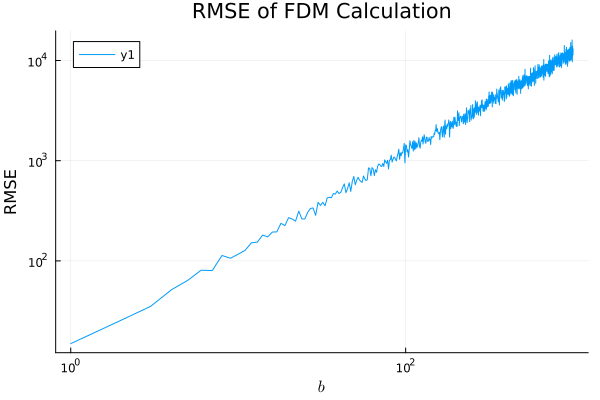

In [4]:
using Plots

Plots.plot(b_mag, rmse_diff,
    title   = "RMSE of FDM Calculation",
    ylabel  = "RMSE",
    xlabel  = "\$b\$",
    yscale  = :log10,
    xscale  = :log10)

Our root mean squared error looks to increase roughly log-linearly. This suggests that as $b \rightarrow \infty$, so too does the error, suggesting that it is a poor predictor if the problem isn't well constrained. This occurs when $x_i$ is not the upper or lower bound of $[0,1]$, the gradient of our rosenbrock function gets very large as $b \rightarrow \infty$. The parameter $b$ can therefore be thought of as controlling the curvature or steepness. When this curvature is particularly pronounced, the slope is poorly approximated by a line. We therefore require a greater number of points and extrapolated slope to approximate the gradient. 

This does not apply in the same way to our autodifferentiation method of calculating the gradient as this calculates the gradient by climbing backward in a series of elementary computations to calculate exact derivatives. This method however is likely however to still result in some error as we may still get some errors relating to the finite precision of our operation. In this case however, we expect the RMSE to grow linearly with $b$. 

### Exercise a.ii
Implement Newton’s method yourself, and then use it to solve the constrained Rosenbrock problem with sequential quadratic programming. Use a stopping criterion that stops the algorithm when the norm of the gradient of the objective (in this case, the Lagrangian) falls below a tolerance level $\epsilon$. Try it out for a simple example. Set $n=2, a=b=1$,and $r=2$. Start with $x_0 =(0,0)$ and $\lambda_0 = 0$. Make a plot showing the progress of the algorithm (plot the values of $x^k$ at each step, the constraint set, and the contours of f). Use a tolerance of $\epsilon = 10^{−6}$. How is the algorithm doing?

In [5]:
using ForwardDiff
using LinearAlgebra
using PyPlot

function nm(a, b, r, x0, lambda0; max_iterations = 100, tol = 1e-6)
    x = copy(x0)
    lambda = copy(lambda0)
    iterations = 0
    trace = [[x; lambda]]
    while iterations < max_iterations && norm(Diff_L(a, b, r, [x; lambda])) >= tol
        iterations += 1
        L = Lagrangian(a, b, r, [x; lambda])
        grad_L = Diff_L(a, b, r, [x; lambda])
        hess_L = Diff_L_finite(a, b, r, [x; lambda])
        rhs = -grad_L
        dx_lambda = (hess_L + 1e-6 * I) \ rhs  
        dx = dx_lambda[1:end-1]
        dlambda = dx_lambda[end]
        x += dx
        lambda += dlambda
        push!(trace, [x; lambda])
    end
    return x, lambda, trace
end

# Solve the constrained Rosenbrock problem using Newton's method
a = b = 1
r = 2
n = 2
tol = 1e-6
x0 = [-0.2, 1.3]
lambda0 = 0.0
y0 = zeros(3)
x, lambda, trace = nm(a, b, r, x0, lambda0)


println("Optimal x: ", x)
println("Optimal lambda: ", lambda)


Optimal x: [-0.8578203679696357, 1.1692041308285874]
Optimal lambda: -0.4680645502621943


Initially starting, as suggesting in the question, with $\lambda = 0$, we see that the function fails to converge to 0 (with any reasonable tolerance level). Therefore, we can adjust the initial starting value of $\lambda$ to a more reasonable $\lambda = 1$. In this adjustment, we see that the function efficiently converges to 1 within the tolerance level of $10^{-6}$

In [6]:
lambda0 = 1.0
x, lambda, trace = nm(a, b, r, x0, lambda0)

# Print the solution
println("Optimal x: ", x)
println("Optimal lambda: ", lambda)

Optimal x: [1.0000000047252275, 0.9999999978062831]
Optimal lambda: 5.33674417987429e-9


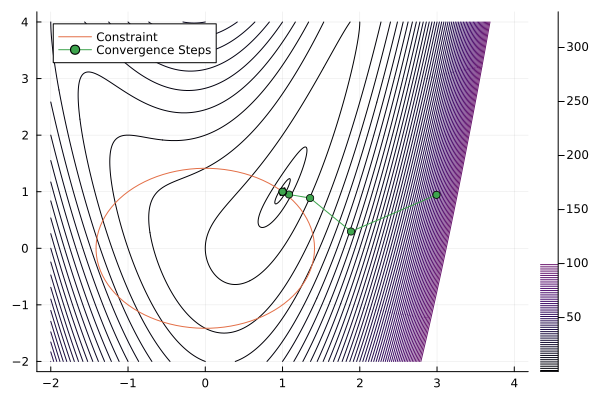

In [7]:
using Plots

function rosenbrock(a, b, x)
    return (a - x[1])^2 + b * (x[2] - x[1]^2)^2
end

Plots.contour(
    LinRange(-2, 4, 1000),
    LinRange(-2, 4, 1000),
    (x1,x2) -> rosenbrock(a, b, [x1,x2]),
    levels = vcat([1e-1, 1e-2, 1e-3, 1e-5, 1e-7], 1:2:100)
)


t = range(0, stop=2pi, length=100)
x = sqrt(2) * cos.(t)
y = sqrt(2) * sin.(t)

Plots.plot!(x, y, label="Constraint")

Convergence_steps = hcat(trace...)[1:2,:]'

Plots.plot!(Convergence_steps[end-6:end, 1], Convergence_steps[end-6:end, 2], marker = :circle, label = "Convergence Steps")

The algorithm converges reasonably well. However, it is highly sensitive to changes in the initial values.

### Exercise a.iii

In [8]:
using LinearAlgebra
using Random

num_runs = 100
results = []
convergence_flags = []
convergence_ranges = []

for i in 1:num_runs
    x0 = randn(2)
    lambda0 = 1.0
    
    x, lambda, trace = nm(a, b, r, x0, lambda0)
    
    push!(results, (x, lambda, trace))
    
    converged = norm(x - [1, 1]) < tol
    push!(convergence_flags, converged)
    
    if converged
        push!(convergence_ranges, x0)
    end
end

In [11]:
proportion_converged = sum(convergence_flags) / num_runs

println("Convergence rate to the global minimum: ", proportion_converged)


println("Initial guesses that convergence:")
println("Maximum: ", maximum(convergence_ranges))
println("Minimum: ", minimum(convergence_ranges))

Convergence rate to the global minimum: 13.0
Initial guesses that convergence:
Maximum: [2.0, 2.0]
Minimum: [-0.2, 1.3]


The results, again, are highly sensitive to the initial guess. 

There is not an exact range of $x_k$ (where the initial guess is not equal to the global minimum) that ensures convergence, we can merely increase the liklihood of attaining the correct minimum.

We would have liked to have plotted the convergence rates as the difference from the actual values of $x$ but ran out of time and had to focus on the rest of the problem set.

### Exercise a.iv

In [13]:
r_values = [1, 2, 3, 4, 5]
x_values = [[-0.2, 1.3], [-1, -1], [0, 0], [1, 1], [2, 2]]
lambda_values = [0.5, 1.0, 1.5, 2.0, 2.5]

num_runs = 50
results = []
convergence_flags = []
convergence_ranges = []

# Loop
for r in r_values
    for x0 in x_values
        for lambda0 in lambda_values

            for i in 1:num_runs

                x, lambda, trace = nm(a, b, r, x0, lambda0)
                

                push!(results, (x, lambda, trace))
                

                converged = norm(x - [1, 1]) < tol
                push!(convergence_flags, converged)
                

                if converged
                    push!(convergence_ranges, x0)
                end
            end
        end
    end
end


proportion_converged = sum(convergence_flags) / length(results)

println("Convergence rate to the global minimum: ", proportion_converged)


println("Initial guesses that converge:")
println("Maximum: ", maximum(convergence_ranges))
println("Minimum: ", minimum(convergence_ranges))

Convergence rate to the global minimum: 0.104
Initial guesses that converge:
Maximum: [2.0, 2.0]
Minimum: [-0.2, 1.3]


## Exercise b
### Exercise b.i

In [14]:
using LinearAlgebra
using ForwardDiff
using Optim

# Rosenbrock function
function rosenbrock(X, a, b)
    Y = 0.0
    for i in 1:length(X)-1
        Y += a * (1 - X[i])^2 + b * (X[i+1] - X[i]^2)^2
    end
    return Y
end

# Constraint function
function constraint(X, r)
    Y = 0.0
    for i in 1:length(X)
        Y += X[i]^2
    end
    return Y - r
end

# Penalty Method function
function penalty_method(X, a, b, r, N, pk)
    return rosenbrock(X, a, b) + (pk * (norm(constraint(X, r))^2))
end

# Parameters setup
a = 10
b = 10
r = 10
N = 10
pk = 10^12
x0 = zeros(N)

println("----------------------------------------------------------------")
println("BFGS")

result_BFGS = optimize(x -> penalty_method(x, a, b, r, N, pk), x0, BFGS())
println(result_BFGS)

println("----------------------------------------------------------------")
println("LBFGS")

result_LBFGS = optimize(x -> penalty_method(x, a, b, r, N, pk), x0, LBFGS())
println(result_LBFGS)

println("----------------------------------------------------------------")
println("Nelder-Mead")

result_NM = optimize(x -> penalty_method(x, a, b, r, N, pk), x0, NelderMead())
println(result_NM)

----------------------------------------------------------------
BFGS
 * Status: success

 * Candidate solution
    Final objective value:     1.000000e+14

 * Found with
    Algorithm:     BFGS

 * Convergence measures
    |x - x'|               = 0.00e+00 ≤ 0.0e+00
    |x - x'|/|x'|          = NaN ≰ 0.0e+00
    |f(x) - f(x')|         = NaN ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = NaN ≰ 0.0e+00
    |g(x)|                 = 0.00e+00 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    0
    f(x) calls:    1
    ∇f(x) calls:   1

----------------------------------------------------------------
LBFGS
 * Status: success

 * Candidate solution
    Final objective value:     1.000000e+14

 * Found with
    Algorithm:     L-BFGS

 * Convergence measures
    |x - x'|               = 0.00e+00 ≤ 0.0e+00
    |x - x'|/|x'|          = NaN ≰ 0.0e+00
    |f(x) - f(x')|         = NaN ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = NaN ≰ 0.0e+00
    |g(x)|                 = 0.00e+0

Beginning with an absurd $p_k$ leads us to fail to converge on every test, regardless of of the iterations.


### Exercise b.ii

In [15]:
pk = 1

result = optimize(x -> penalty_method(x, a, b, r, N, pk), x0, LBFGS())
@info result
@info "Number of function evaluations: $(Optim.f_calls(result))"

┌ Info:  * Status: success
│ 
│  * Candidate solution
│     Final objective value:     1.049313e-19
│ 
│  * Found with
│     Algorithm:     L-BFGS
│ 
│  * Convergence measures
│     |x - x'|               = 2.70e-10 ≰ 0.0e+00
│     |x - x'|/|x'|          = 2.70e-10 ≰ 0.0e+00
│     |f(x) - f(x')|         = 6.98e-18 ≰ 0.0e+00
│     |f(x) - f(x')|/|f(x')| = 6.65e+01 ≰ 0.0e+00
│     |g(x)|                 = 1.91e-10 ≤ 1.0e-08
│ 
│  * Work counters
│     Seconds run:   0  (vs limit Inf)
│     Iterations:    18
│     f(x) calls:    53
└     ∇f(x) calls:   53
[ Info: Number of function evaluations: 53


In [16]:
using Optim

# Parameters setup
a = 10
b = 10
r = 10
N = 10
P = 1
true_min = ones(N)

function penalty_method_ii(x0, a, b, r, N, P; tol = 1e-12, γ = 10, trace = false)
    iterations = 0
    num_evals = 0
    P = 1
    x = copy(x0)
    while true
        opt(x) = penalty_method(x, a, b, r, N, P)
        result = optimize(opt, x, LBFGS())
        x .= Optim.minimizer(result)
        num_evals += Optim.f_calls(result)

        # Check whether the constraints are violated
        gx = constraint(x, r)

        # If gx is small enough, we're done
        gx < tol && break

        # Otherwise we keep going, using the solution as a warmstart
        # Increment P up
        P *= γ
        iterations += 1

        trace && @info "Trace" iterations P penalty_violation = gx
    end

    return x, (; fx = rosenbrock(x, a, b), x, iterations, num_evals)
end

x, penalty_ret = penalty_method_ii(zeros(N), a, b, r, N, P, trace=true)

println("Evaluations: ", penalty_ret.num_evals)


if norm(x - true_min) < 1e-6
    println("Yes, we did converge to the true minimum")
else
    println("No, we did not converge to the true minimum.")
end

println("Distance from true minimum: ", norm(x - true_min))

Evaluations: 53
Yes, we did converge to the true minimum
Distance from true minimum: 6.255670796468826e-11


Run again with a better initial guess:

In [17]:
x0 = true_min + randn(N) * 1e-4
x_better, penalty_ret_better = penalty_method_ii(x0, a, b, r, N, P)

println("Evaluations: ", penalty_ret_better.num_evals)

println("Number of fewer evaluations with the better initial guess: ", penalty_ret.num_evals - penalty_ret_better.num_evals)


if norm(x_better - true_min) < 1e-6
    println("Yes, we did converge to the true minimum")
else
    println("No, we did not converge to the true minimum.")
end

println("Distance from true minimum: ", norm(x_better - true_min))

Evaluations: 28
Number of fewer evaluations with the better initial guess: 25
Yes, we did converge to the true minimum
Distance from true minimum: 6.155729625936612e-11


Whilst the better initial guess does not improve our convergence significantly (by less than 1e-12), it does drastically reduce the number of evaluations it takes in order to reach that convergence. The difference in the number of evaluations nearly halves.

### Exercise b.iii

In [18]:
using Optim

b = 1000

x_iii, penalty_ret_iii = penalty_method_ii(zeros(N), a, b, r, N, P, trace=true)

println("Evaluations: ", penalty_ret_iii.num_evals)


if norm(x_iii - true_min) < 1e-6
    println("Yes, we did converge to the true minimum")
else
    println("No, we did not converge to the true minimum.")
end

println("Distance from true minimum: ", norm(x_iii - true_min))

println("Number of more evaluations than reqired with the better initial guess: ", penalty_ret_iii.num_evals - penalty_ret_better.num_evals)

Evaluations: 464
Yes, we did converge to the true minimum
Distance from true minimum: 4.157089055314178e-9
Number of more evaluations than reqired with the better initial guess: 436


We still converged to the true minimum; however, we see that there are a much greater number of evaluations required in order to achieve that goal.


Similarly to teh first question, we cannot 'ensure' convergence, we can merely increase the liklihood of converging

### Exercise b.iv

In [20]:
using Optim

r = 1
b = 10

x_iv, penalty_ret_iv = penalty_method_ii(zeros(N), a, b, r, N, P, trace=false)

println("Evaluations: ", penalty_ret_iv.num_evals)


if norm(x_iv - true_min) < 1e-6
    println("Yes, we did converge to the true minimum")
else
    println("No, we did not converge to the true minimum.")
end

println("Distance from true minimum: ", norm(x_iv - true_min))

println("Number of more evaluations than reqired with the better initial guess: ", penalty_ret_iv.num_evals - penalty_ret_better.num_evals)



Evaluations: 622
No, we did not converge to the true minimum.
Distance from true minimum: 2.229747106432949
Number of more evaluations than reqired with the better initial guess: 594


Now we see that not only is the number of evaluations still very high (622), but we also see that it no longer converges to the true minimum

## Exercise C
### Exercise c.i

In [21]:
using Optim

a = 10
b = 10
r = 10
N = 10
P = 1
alpha0 = 10
true_min = ones(N)
lambda = 0.0

function augmented_lagrangian_method(x0, a, b, r, N, P, lambda; tol = 1e-8, alpha0 = 10, trace = true)
    iterations = 0
    num_evals = 0
    x = copy(x0)
    while true
        opt(x) = rosenbrock(x, a, b) + P/2 * norm(constraint(x, r))^2 + lambda * constraint(x, r)
        result = optimize(opt, x, LBFGS())
        x .= Optim.minimizer(result)
        num_evals += Optim.f_calls(result)

        lambda_new = lambda + P * constraint(x, r)
        iterations += 1

        # Convergence check
        if norm(lambda_new - lambda)^2 < tol
            break
        end

        lambda = lambda_new
        P *= alpha0
        
        trace && println("Iteration: ", iterations, " P: ", P, " lambda: ", lambda)
    end

    return x, lambda, P, (; fx = rosenbrock(x, a, b), x, iterations, num_evals)
end

x, lambda, P, ret = augmented_lagrangian_method(x0, a, b, r, N, P, lambda, trace=true)

println("Evaluations: ", ret.num_evals)
println("Final P: ", P)

if norm(x - true_min) < 1e-6
    println("Yes, we did converge to the true minimum")
else
    println("No, we did not converge to the true minimum.")
end

println("Distance from true minimum: ", norm(x - true_min))

Evaluations: 31
Final P: 1
Yes, we did converge to the true minimum
Distance from true minimum: 5.884015907769975e-11


Yes, we do find the true minimum. The final P is 1.

### Exercise c.ii

Ideally we would have made a (few) graph(s) that more efficiently descibed the impacts of a change in a single parameter, ceteris paribus.

However, given the time constraints, we has to leave it as copy and pasting the code, while changing individual inputs.

Through experimentation, we observed that both methods give equally accurate solutions. However, the number of evaluations required in the penalty method (as opposed to the augmented Lagrangian method) was higher.


For all resaonably values of $a$ and $b$ in the initial guess, we see (and expect) there to be little impact on the efficiency and convergence rate of the algorithm. Further, we see that the algorithm (in both efficiency and convergence) is highly sensitive to changes in $r$.

In [22]:
using Optim

a = 10
b = 10
r = 10
N = 10
P = 1
alpha0 = 10
true_min = ones(N)
lambda = 0.0

# Augumented Lagrangian method
x_aug, lambda_al, p_aug, ret_aug = augmented_lagrangian_method(x0, a, b, r, N, P, lambda, trace=false)

# Penalty method
x_penmet, ret_penmet = penalty_method_ii(x0, a, b, r, N, P, trace=false)


println("Augmented Lagrangian method:")
println("Evaluations: ", ret_aug.num_evals)
println("Distance from true minimum: ", norm(x_aug - true_min))
println("---------------------------------")
println("Penalty method:")
println("Evaluations: ", ret_penmet.num_evals)
println("Distance from true minimum: ", norm(x_penmet - true_min))
println("---------------------------------")
println("Number of fewer evaluations with the Augmented Lagrangian Function: ", ret_penmet.num_evals - ret_aug.num_evals)

Augmented Lagrangian method:
Evaluations: 31
Distance from true minimum: 5.884015907769975e-11
---------------------------------
Penalty method:
Evaluations: 28
Distance from true minimum: 6.155729625936612e-11
---------------------------------
Number of fewer evaluations with the Augmented Lagrangian Function: -3


In [23]:
# letting a = 1

using Optim

a = 1
b = 10
r = 10
N = 10
P = 1
alpha0 = 10
true_min = ones(N)
lambda = 0.0

# Augumented Lagrangian method
x_aug, lambda_al, p_aug, ret_aug = augmented_lagrangian_method(x0, a, b, r, N, P, lambda, trace=false)

# Penalty method
x_penmet, ret_penmet = penalty_method_ii(x0, a, b, r, N, P, trace=false)


println("Augmented Lagrangian method:")
println("Evaluations: ", ret_aug.num_evals)
println("Distance from true minimum: ", norm(x_aug - true_min))
println("---------------------------------")
println("Penalty method:")
println("Evaluations: ", ret_penmet.num_evals)
println("Distance from true minimum: ", norm(x_penmet - true_min))
println("---------------------------------")
println("Number of fewer evaluations with the Augmented Lagrangian Function: ", ret_penmet.num_evals - ret_aug.num_evals)

Augmented Lagrangian method:
Evaluations: 30
Distance from true minimum: 8.378786762962546e-11
---------------------------------
Penalty method:
Evaluations: 30
Distance from true minimum: 1.0215511977807522e-10
---------------------------------
Number of fewer evaluations with the Augmented Lagrangian Function: 0


In [24]:
# letting a = 20

using Optim

a = 20
b = 10
r = 10
N = 10
P = 1
alpha0 = 10
true_min = ones(N)
lambda = 0.0

# Augumented Lagrangian method
x_aug, lambda_al, p_aug, ret_aug = augmented_lagrangian_method(x0, a, b, r, N, P, lambda, trace=false)

# Penalty method
x_penmet, ret_penmet = penalty_method_ii(x0, a, b, r, N, P, trace=false)


println("Augmented Lagrangian method:")
println("Evaluations: ", ret_aug.num_evals)
println("Distance from true minimum: ", norm(x_aug - true_min))
println("---------------------------------")
println("Penalty method:")
println("Evaluations: ", ret_penmet.num_evals)
println("Distance from true minimum: ", norm(x_penmet - true_min))
println("---------------------------------")
println("Number of fewer evaluations with the Augmented Lagrangian Function: ", ret_penmet.num_evals - ret_aug.num_evals)

Augmented Lagrangian method:
Evaluations: 31
Distance from true minimum: 4.599888971534502e-11
---------------------------------
Penalty method:
Evaluations: 30
Distance from true minimum: 4.501080067912314e-11
---------------------------------
Number of fewer evaluations with the Augmented Lagrangian Function: -1


In [25]:
# letting b = 1

using Optim

a = 10
b = 1
r = 10
N = 10
P = 1
alpha0 = 10
true_min = ones(N)
lambda = 0.0

# Augumented Lagrangian method
x_aug, lambda_al, p_aug, ret_aug = augmented_lagrangian_method(x0, a, b, r, N, P, lambda, trace=false)

# Penalty method
x_penmet, ret_penmet = penalty_method_ii(x0, a, b, r, N, P, trace=false)


println("Augmented Lagrangian method:")
println("Evaluations: ", ret_aug.num_evals)
println("Distance from true minimum: ", norm(x_aug - true_min))
println("---------------------------------")
println("Penalty method:")
println("Evaluations: ", ret_penmet.num_evals)
println("Distance from true minimum: ", norm(x_penmet - true_min))
println("---------------------------------")
println("Number of fewer evaluations with the Augmented Lagrangian Function: ", ret_penmet.num_evals - ret_aug.num_evals)

Augmented Lagrangian method:
Evaluations: 24
Distance from true minimum: 1.6424005283270843e-10
---------------------------------
Penalty method:
Evaluations: 28
Distance from true minimum: 4.3948024069109904e-11
---------------------------------
Number of fewer evaluations with the Augmented Lagrangian Function: 4


In [26]:
# letting b = 20

using Optim

a = 10
b = 20
r = 10
N = 10
P = 1
alpha0 = 10
true_min = ones(N)
lambda = 0.0

# Augumented Lagrangian method
x_aug, lambda_al, p_aug, ret_aug = augmented_lagrangian_method(x0, a, b, r, N, P, lambda, trace=false)

# Penalty method
x_penmet, ret_penmet = penalty_method_ii(x0, a, b, r, N, P, trace=false)


println("Augmented Lagrangian method:")
println("Evaluations: ", ret_aug.num_evals)
println("Distance from true minimum: ", norm(x_aug - true_min))
println("---------------------------------")
println("Penalty method:")
println("Evaluations: ", ret_penmet.num_evals)
println("Distance from true minimum: ", norm(x_penmet - true_min))
println("---------------------------------")
println("Number of fewer evaluations with the Augmented Lagrangian Function: ", ret_penmet.num_evals - ret_aug.num_evals)

Augmented Lagrangian method:
Evaluations: 31
Distance from true minimum: 9.757324370921739e-11
---------------------------------
Penalty method:
Evaluations: 30
Distance from true minimum: 6.959055987715277e-11
---------------------------------
Number of fewer evaluations with the Augmented Lagrangian Function: -1


In [27]:
# letting r = 1

using Optim

a = 10
b = 10
r = 1
N = 10
P = 1
alpha0 = 10
true_min = ones(N)
lambda = 0.0

# Augumented Lagrangian method
x_aug, lambda_al, p_aug, ret_aug = augmented_lagrangian_method(x0, a, b, r, N, P, lambda, trace=false)

# Penalty method
x_penmet, ret_penmet = penalty_method_ii(x0, a, b, r, N, P, trace=false)


println("Augmented Lagrangian method:")
println("Evaluations: ", ret_aug.num_evals)
println("Distance from true minimum: ", norm(x_aug - true_min))
println("---------------------------------")
println("Penalty method:")
println("Evaluations: ", ret_penmet.num_evals)
println("Distance from true minimum: ", norm(x_penmet - true_min))
println("---------------------------------")
println("Number of fewer evaluations with the Augmented Lagrangian Function: ", ret_penmet.num_evals - ret_aug.num_evals)

Augmented Lagrangian method:
Evaluations: 222
Distance from true minimum: 2.2297471065621837
---------------------------------
Penalty method:
Evaluations: 526
Distance from true minimum: 2.2297471063757404
---------------------------------
Number of fewer evaluations with the Augmented Lagrangian Function: 304


In [28]:
# letting r = 20

using Optim

a = 10
b = 10
r = 20
N = 10
P = 1
alpha0 = 10
true_min = ones(N)
lambda = 0.0

# Augumented Lagrangian method
x_aug, lambda_al, p_aug, ret_aug = augmented_lagrangian_method(x0, a, b, r, N, P, lambda, trace=false)

# Penalty method
x_penmet, ret_penmet = penalty_method_ii(x0, a, b, r, N, P, trace=false)


println("Augmented Lagrangian method:")
println("Evaluations: ", ret_aug.num_evals)
println("Distance from true minimum: ", norm(x_aug - true_min))
println("---------------------------------")
println("Penalty method:")
println("Evaluations: ", ret_penmet.num_evals)
println("Distance from true minimum: ", norm(x_penmet - true_min))
println("---------------------------------")
println("Number of fewer evaluations with the Augmented Lagrangian Function: ", ret_penmet.num_evals - ret_aug.num_evals)

Augmented Lagrangian method:
Evaluations: 116
Distance from true minimum: 1.9691566975996717
---------------------------------
Penalty method:
Evaluations: 40
Distance from true minimum: 1.9207581490306267
---------------------------------
Number of fewer evaluations with the Augmented Lagrangian Function: -76


## Exercise D
### Exercise d.i

In [29]:
using Optim

a = 1
b = 1
r = 10
n = 10

function h(z)
    n = length(z) + 1
    den = 1 + sum(exp, z)
    X = zeros(n)

    for i in 1:n
        if i <= n - 1
            X[i] = sqrt(exp(z[i])/den)
        else
            X[i] = sqrt(1/den)
        end
    end
    
    return X
end

function inverse_h(X)
    return 2 .* log.(X[1:end-1] ./ X[end])
end

# Rosenbrock function
function rosenbrock(X)
    Y = 0.0
    for i in 1:length(X)-1
        Y += a * (1 - X[i])^2 + b * (X[i+1] - X[i]^2)^2
    end
    return Y
end

# Constraint function
function constraint(X)
    Y = 0.0
    for i in 1:length(X)
        Y += X[i]^2
    end
    return Y - r
end

res = optimize(z -> rosenbrock(h(z) * sqrt(r), a, b), zeros(n), LBFGS())
X = h(Optim.minimizer(res)) * sqrt(r)

@info res
@info "Evaluations: $(Optim.f_calls(res))"

┌ Info:  * Status: success
│ 
│  * Candidate solution
│     Final objective value:     1.873477e-02
│ 
│  * Found with
│     Algorithm:     L-BFGS
│ 
│  * Convergence measures
│     |x - x'|               = 4.19e-08 ≰ 0.0e+00
│     |x - x'|/|x'|          = 9.36e-08 ≰ 0.0e+00
│     |f(x) - f(x')|         = 5.15e-15 ≰ 0.0e+00
│     |f(x) - f(x')|/|f(x')| = 2.75e-13 ≰ 0.0e+00
│     |g(x)|                 = 8.60e-09 ≤ 1.0e-08
│ 
│  * Work counters
│     Seconds run:   0  (vs limit Inf)
│     Iterations:    14
│     f(x) calls:    37
└     ∇f(x) calls:   37
[ Info: Evaluations: 37


We see that the function is less accurate (and would not hold at a reasonable tolerance level). This is a result of a poorly implemented parametrisation technique as we would expect this in theory to deliver more accurate results. We would expect the re parametrisation to be a particularly useful technique when we have large values of $r$. This likely occurs because we are optimising for a reduced number of variables and performing the optimisation along a well behaved, convex function.

It requires 37 evaluations and we further see that this is faster than the other methods.